# Simple foveation model
Uses "Fast irregular domain node layout" algorithm to layout nodes in roughly retinal fashion.
The retinal sampling is performed using a Gaussian pyramid, in this case with $\sqrt(2)$ pyramid levels. This version performs no interpolation at all, though it would be trivial to implement an accelerated version in hardware using trilinear filtering (built into every GPU).

In [146]:
from __future__ import print_function, division
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from skimage.transform import pyramid_gaussian, pyramid_expand
from variable_density import moving_front_nodes
%matplotlib inline


In [147]:
def density_fn(x,y, k=0.01):    
    return (0.25*k+np.exp(-(x**2+y**2)**0.5*10.0))  / (0.01 * k)
    
nodes = moving_front_nodes(density_fn, (-2.0, -2.0, 2.0, 2.0), new_pts=5, init_pts=1000)

In [148]:
# compute shifted pattern, clipping nodes out of range
# look_at is the position we are looking at in, in normalized -1,1 coordinates
look_at = np.array((-0.2,0.45))
look_nodes = nodes + look_at
# clip out of range nodes
look_nodes = look_nodes[np.max(np.abs(look_nodes), axis=1)<1]

# compute mip-map level of each node (root 2 octaves here)
octave =  np.sqrt(2.0)

resolution = 512
density = 1.0/resolution
# find the layer we should read from
# this is in comparison to the real pixel density (1/resolution), so that a density
# of points equal to the pixel density will sample from the lowest mip-map level (level 0)
node_scale = np.array([-np.round(np.log(1.0/np.sqrt(density_fn(x,y)))/np.log(octave)) for x,y in look_nodes-look_at])
log_density = np.log(density)/np.log(octave)
mips = -log_density - node_scale
# can't sample finer than the finest level!
mips = np.maximum(mips, 0)
node_mapped = np.array([(x, y, s) for ((x,y), s) in zip(look_nodes, mips)])

(-1, 1)

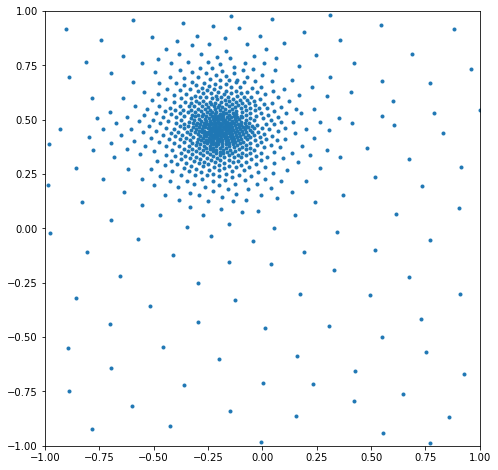

In [149]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.plot(look_nodes[:,0], look_nodes[:,1], '.')
ax.axis("image")
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
    

In [150]:
# load an image
import skimage.io
face = skimage.io.imread("imgs/kodim17.png")
# form the gaussian pyramid; layer 0 is original resolution; layer 1 is 1.0/octave smaller, etc.
imgs = tuple(pyramid_gaussian(face, downscale=octave))

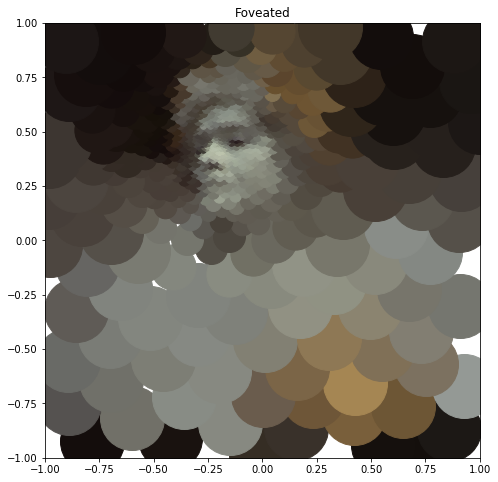

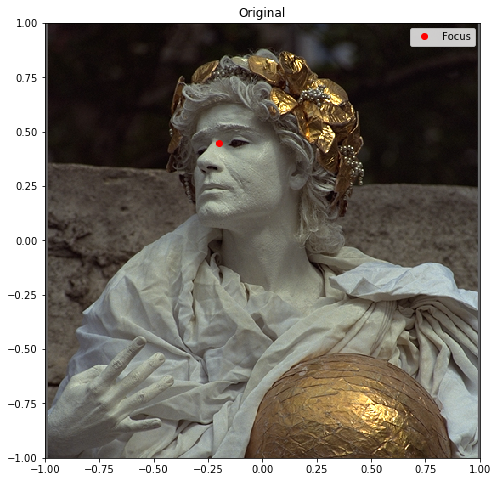

In [152]:
# show the image sampled retinally, with simple
# hexagonal point markers (very slow to render!)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)

# plot each point... individually
for (nx,ny,l),(rx,ry) in zip(node_mapped, look_nodes):    
    # convert normalized coordinates to pixel lookups
    layer = imgs[int(l-1)]
    x, y = int((0.5*nx+0.5)  * layer.shape[1]), int((0.5*ny+0.5) * layer.shape[0])
    # flip y for display
    pix = np.clip(layer[-y,x],0,1)
    ax.plot(rx, ry, 'o', color=pix, markersize=octave**(l+1)*0.5)
        
ax.set_aspect(1.0)    
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
plt.title("Foveated")

# show the reference original image, along with the foveation point
plt.figure(figsize=(8,8))
plt.imshow(face, extent=[-1,1,-1,1])
plt.plot(look_at[0], look_at[1], 'ro', label='Focus')
plt.legend()
plt.title("Original")